Need:


1. Audio Features
2. Lyrical Features  (emotion, bag of words tfidf)
3. Page Ranked Artist (for recommendaiton)
4. Look at similarity of songs to see where other songs ranked


In [1]:
from pymongo import MongoClient
from pprint import pprint
from typing import List
from functools import reduce
from operator import add
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse


# DB CONFIG
client = MongoClient('mongo', 27017)
db = client.music_db
COLLECTION = db['part5-hot100-songs']


def get_songs(collection):
    return list(collection.find())

def has_spotify(song):
    return song.get('spotify', {}).get('audio_features')

def has_lyrics(song):
    if not song.get('lyrics'):
        return False
    
    if song.get('lyrics') == 'null':
        return False

    if song.get('lyrics').get('error'):
        return False
    
    if not song.get('tokens'):
        return False

    return True


SONGS = get_songs(COLLECTION)
songs = list(filter(has_lyrics, filter(has_spotify, SONGS)))

(168, 80)

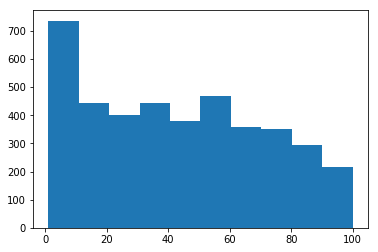

In [2]:
pos = [song['peakPos'] for song in songs]
plt.hist(pos)

from collections import Counter
Counter(pos)[1], Counter(pos)[2]

In [3]:
import numpy as np
import pandas as pd
import copy
pd.options.display.max_columns = None

def to_df(songs):
    df = pd.DataFrame(songs)
    df = df.drop(columns=['_id', 'id', 'identifier', 'lyrics', 'genre', 'isNew', 'lastPos', 'rank', 'weeks', 'track_href', 'type', 'uri', 'spotify', 'analysis_url'])
    df['lyrics_length'] = df['raw_lyrics'].apply(lambda lyrics: len("".join(lyrics.split('\n'))))
    return df
    
df = to_df(songs)
#df.head()

In [4]:
y = pd.DataFrame(df['peakPos'])
X = df.drop(['peakPos', 'artist', 'raw_lyrics', 'title', 'tokens'], axis=1)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_lyrics(songs):
    lyrics_list = [" ".join(song['tokens']) for song in songs]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list)
    tfidf_array = tfidf_matrix.toarray()
    
    for vector, song in zip(tfidf_array, songs):
        song['tfidf'] = vector
    
    return tfidf_matrix
    
def vectorize_df_lyrics(df):
    lyrics_df = df['tokens'].apply(" ".join).values
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_df)    
    return tfidf_matrix.toarray()
    
tfidf_matrix = vectorize_lyrics(songs)

In [6]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(tfidf_matrix, metric="cosine")

In [7]:
from sklearn.model_selection import train_test_split  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  
y_true = y_test.values.reshape(-1)

In [8]:
def tfidf_index(indexes, tfidf_matrix):
    return np.vstack([tfidf_matrix[index].toarray() for index in indexes])

def distance_index(indexes, distances):
    return np.vstack([distances[index] for index in indexes])


tfidf_mat_X_train = tfidf_index(X_train.index.values, tfidf_matrix)
tfidf_mat_X_test = tfidf_index(X_test.index.values, tfidf_matrix)

distance_X_train = distance_index(X_train.index.values, distances)
distance_X_test = distance_index(X_test.index.values, distances)

In [9]:
print(type(tfidf_mat_X_train), tfidf_mat_X_train.shape)  # 5572 doc, tfidf 100 dimension

<class 'numpy.ndarray'> (3064, 17830)


In [10]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [11]:
X_train[0]

array([-0.69152798, -0.46069427,  0.44707558,  0.68927217, -0.60135846,
       -0.90359886,  1.68466497,  0.90557492,  0.62971105, -0.4306852 ,
       -1.03815458,  0.13378647,  0.33967262, -1.0291864 ])

In [12]:
len(tfidf_mat_X_train[0]) + len(X_train[0]) + len(distances[0])

21930

In [13]:
import copy

def combine_features(tfidf_matrix_train, distances, train_features):
    combined_matrix = []
    for tfidf, distance, features in zip(tfidf_matrix_train, distances, train_features):
        combined = np.hstack([tfidf, features])  #features, tfidf, distance, 
        combined_matrix.append(combined)
    return np.vstack(combined_matrix)

_combined_X_train = combine_features(tfidf_mat_X_train, distance_X_train, X_train)
_combined_X_test = combine_features(tfidf_mat_X_test, distance_X_test, X_test)

In [14]:
combined_X_train = _combined_X_train
combined_X_test = _combined_X_test

In [15]:
combined_X_train[0].shape

(17844,)

In [16]:
# Fit regression model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred):
    x, y = [], []
    for true, pred in zip(y_true, y_pred):
        diff = abs(true - pred)
        
    length = len(y_true)
    plt.plot(y_true, 'bo')
    plt.plot(y_pred, 'ro')
    
    
def plot_sorted_predictions(y_true, y_pred):
    true, pred = zip(*sorted(zip(y_true, y_pred)))
    plt.plot(true, pred, 'bo')


def run_model(model, train=False):

    model.fit(X_train, y_train.values.reshape(-1))
    # Predict
    y_pred = model.predict(X_test)
    y_pred = [min(pred, 100) for pred in y_pred]
    print("Error:", mse(y_true, y_pred))
    plt.figure(figsize=(20,10))
    plot_predictions(y_true, y_pred)
    return y_pred


from collections import defaultdict

def find_avg_guess_per_rank(y_true, y_pred):
    buckets = defaultdict(lambda: [])
    for true, pred in zip(y_true, y_pred):
        buckets[true].append(pred)
    return buckets


def plot_avg_guesses(y_true, y_pred):
    guesses = find_avg_guess_per_rank(y_true, y_pred)
    plt.plot(sorted(guesses.keys()), [np.mean(guesses[i]) for i in sorted(guesses.keys())])
    return guesses
    

In [243]:
# build model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D


shape = combined_X_train.shape
#input_shape=(17830,)

model = Sequential()
model.add(Dense(64, input_shape=(shape[1],)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                1142080   
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
activation_10 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
activation_11 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
__________

In [244]:
model.fit(combined_X_train, y_train, batch_size=256, epochs=25, verbose=True, validation_split=0.15)

Train on 2604 samples, validate on 460 samples
Epoch 1/25
2604/2604 [==============================] - 1s 550us/step - loss: 2641.9025 - val_loss: 2501.7009
Epoch 2/25
2604/2604 [==============================] - 1s 360us/step - loss: 2603.5527 - val_loss: 2445.6376
Epoch 3/25
2604/2604 [==============================] - 1s 378us/step - loss: 2520.0264 - val_loss: 2328.9473
Epoch 4/25
2604/2604 [==============================] - 1s 308us/step - loss: 2353.7409 - val_loss: 2097.9460
Epoch 5/25
2604/2604 [==============================] - 1s 295us/step - loss: 2044.7364 - val_loss: 1696.8165
Epoch 6/25
2604/2604 [==============================] - 1s 294us/step - loss: 1614.5541 - val_loss: 1178.6553
Epoch 7/25
2604/2604 [==============================] - 1s 294us/step - loss: 1198.4804 - val_loss: 848.9681
Epoch 8/25
2604/2604 [==============================] - 1s 285us/step - loss: 1141.6233 - val_loss: 812.7547
Epoch 9/25
2604/2604 [==============================] - 1s 300us/step - los

Error: 791.366866598


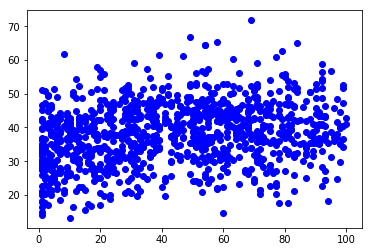

In [245]:
from sklearn.metrics import mean_squared_error as mse


y_pred = model.predict(combined_X_test).reshape(-1)
y_true = y_test.values.reshape(-1)

def print_predictions(y_pred, y_true):
    for true, pred in zip(y_true, y_pred):
        print(true, int(pred))
        

#print_predictions(y_pred, y_true)
print("Error:", mse(y_true, y_pred))
plot_sorted_predictions(y_true, y_pred)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1aae893048>]], dtype=object)

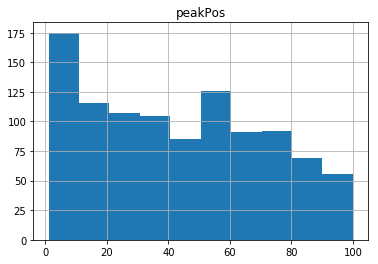

In [246]:
y_test.hist()

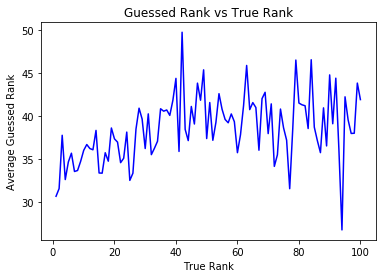

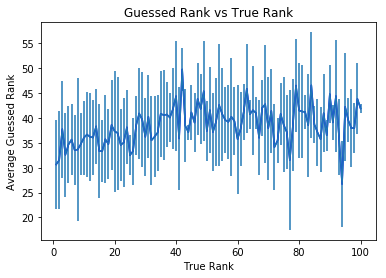

In [247]:
def plot_avg_guesses(y_true, y_pred, error=False):
    guesses = find_avg_guess_per_rank(y_true, y_pred)
    x = sorted(guesses.keys())
    y = [np.mean(guesses[i]) for i in x]
    yerr = [np.std(guesses[i]) for i in x]
    plt.plot(x, y, 'b')
    plt.title("Guessed Rank vs True Rank")
    plt.ylabel("Average Guessed Rank")
    plt.xlabel("True Rank")
    if error:
        plt.errorbar(x, y, yerr=yerr)
    plt.show()

    return guesses

guesses = plot_avg_guesses(y_true, y_pred)
guesses = plot_avg_guesses(y_true, y_pred, True)

In [248]:
import math
from sklearn.metrics import mean_squared_error as mse

def baseline(y_test):
    mean = y_test.peakPos.values.mean()
    guesses = [mean] * len(y_test) 
    return mse(y_test, guesses)

baseline(y_train)


819.67105225596333

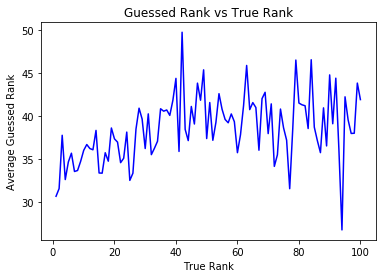

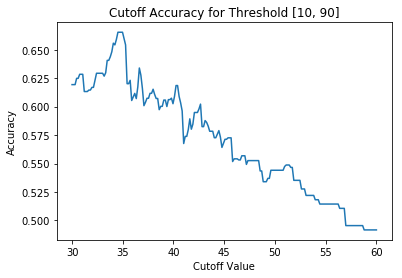

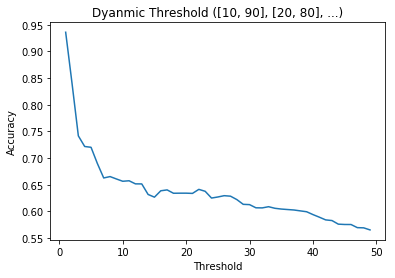

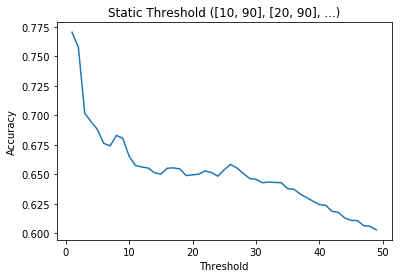

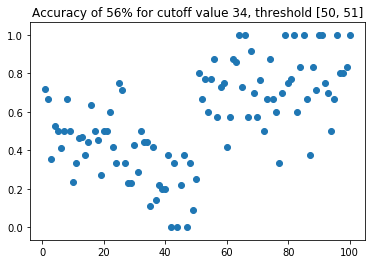

In [249]:
from collections import Counter
from pprint import pprint
from collections import defaultdict
import scipy

def guess_threshold(y_true, y_pred, val=36, low_threshold=20, high_threshold=80):
    guesses = find_avg_guess_per_rank(y_true, y_pred)

    evaluation = defaultdict(list)
    for pos, guesses in guesses.items():
        if high_threshold > pos > low_threshold:
            continue
            
        for guess in guesses:
            if pos <= low_threshold:
                evaluation[pos].append(guess < val)
                    
            if pos >= high_threshold:
                evaluation[pos].append( guess > val)
    return evaluation


def error_fn(val):
    return (1 + val) ** 2

def evaluate_guesses(val, y_true, y_pred, low_threshold=10, high_threshold=91):
    evaluation = guess_threshold(y_true, y_pred, val, low_threshold, high_threshold)

    low_avg = 0
    high_avg = 0
    
    for pos, vals in evaluation.items():
        correct = sum(vals) / len(vals) 
        err = error_fn(correct)
        if pos <= low_threshold:
            low_avg += correct
        else:
            high_avg += correct            
        
    num_high = 101 - high_threshold
    num_low = low_threshold
    total = num_high + num_low

    low_avg /= num_low    
    high_avg /= num_high
                        
    avg = (low_avg + high_avg) / 2
    return avg


def optimize(y_true, y_pred, low_threshold=10, high_threshold=90):
    vals = np.linspace(30, 60, 200)
    
    param, maxi = 0, -1
    
    x, y = [], []
    for i in vals:
        acc = evaluate_guesses(i, y_true, y_pred, low_threshold, high_threshold)
        x.append(i)
        y.append(acc)

        if acc > maxi:
            param = i
            maxi = acc
            
    return param, maxi, [x, y]
    
    
def plot_thresholds(y_true, y_pred):
    x, y = [], []
    
    
    for i in range(1, 50, 1):
        param, accuracy, _ = optimize(y_true, y_pred, i, high_threshold=101-i)
        x.append(i)
        y.append(accuracy)
    
    plt.plot(x, y)
    
    plt.title("Dyanmic Threshold ([10, 90], [20, 80], ...)")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")

    plt.show()
    return x, y


def plot_static_thresholds(y_true, y_pred, static_upper=90):
    x, y = [], []

    
    for i in range(1, 50, 1):
        param, accuracy, _ = optimize(y_true, y_pred, i, high_threshold=static_upper)
        x.append(i)
        y.append(accuracy)
    
    plt.plot(x, y)
    plt.title(f"Static Threshold ([10, {static_upper}], [20, {static_upper}], ...)")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")    
    plt.show()
    return x, y


def plot_optimal_param(y_true, y_pred, low_threshold=10, high_threshold=90):
    param, acc, [x, y] = optimize(y_true, y_pred, low_threshold, high_threshold)
    plt.plot(x, y)
    plt.title(f"Cutoff Accuracy for Threshold [{low_threshold}, {high_threshold}]")
    plt.xlabel("Cutoff Value")
    plt.ylabel("Accuracy")
    plt.show()
    
    
def accuracy_per_position(guess_dict):
    correct = {}
    for rank, guesses in guess_dict.items():
        correct[rank] = sum(guesses) / len(guesses)
    return correct

def plot_accuracy_per_position(y_true, y_pred, low=50, high=51):
    param, acc, _ = optimize(y_true, y_pred, low, high)
    guesses = guess_threshold(y_true, y_pred, param, low, high)
    correct = accuracy_per_position(guesses)
    x, y = zip(*sorted(correct.items()))
    plt.scatter(x, y)
    plt.title(f"Accuracy of {int(acc*100)}% for cutoff value {int(param)}, threshold [{low}, {high}]")

plot_avg_guesses(y_true, y_pred)
plot_optimal_param(y_true, y_pred, 10, 90)
plot_thresholds(y_true, y_pred)
plot_static_thresholds(y_true, y_pred, static_upper=90)
plot_accuracy_per_position(y_true, y_pred)
# # Multiple ranking by how similar, tae the average, make a feature



Error: 761.054586517


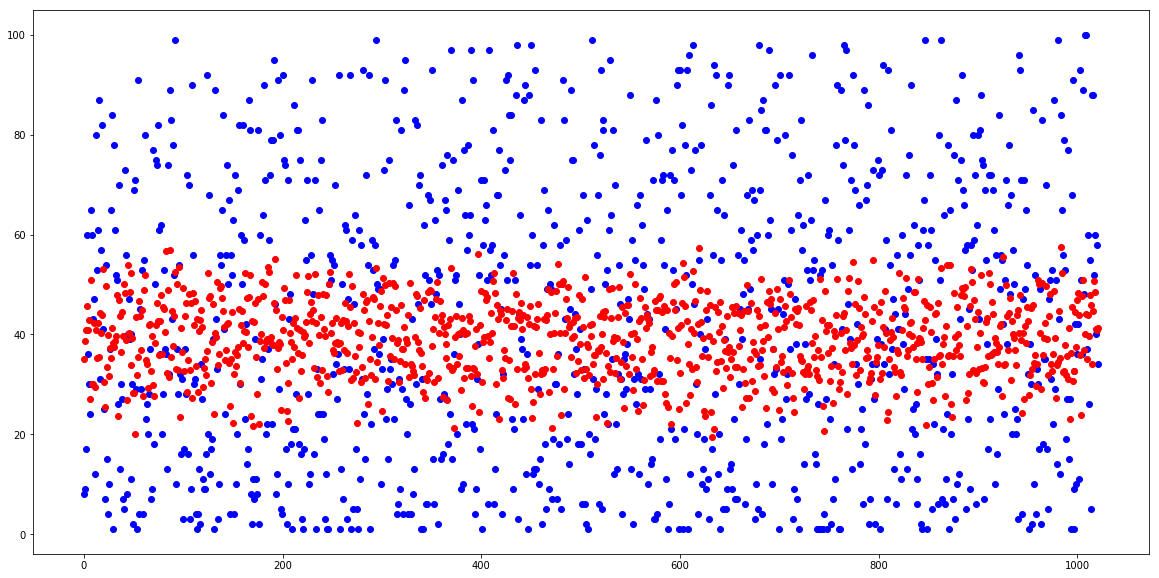

In [250]:
from sklearn.svm import SVR

model = SVR() 
y_pred = run_model(model)

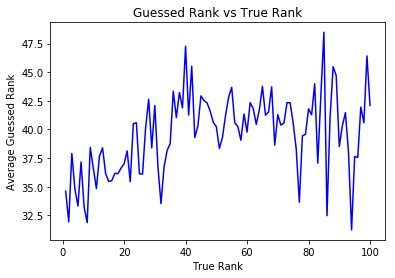

In [251]:
guesses = plot_avg_guesses(y_true, y_pred)